In [143]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import mne

In [144]:
def preprocessing(df):
    df = df.loc[:, ['C5..', 'C3..', 'C1..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.', 'Cp2.', 'Cp4.', 'Cp6.', 'P5..', 'P3..', 'P1..', 'P2..', 'P4..']]
    return df

def resize_row(row, target_columns, fill_value=0):
    """
    Resize a single row to the target number of columns.
    """
    if len(row) > target_columns:
        # Truncate
        return row[:target_columns]
    elif len(row) < target_columns:
        # Pad
        return row + [fill_value] * (target_columns - len(row))
    else:
        return row

def resize_matrix(matrix, target_rows, target_columns, fill_value=0):
    """
    Resize a 2D list (matrix) to the target number of rows and columns.
    """
    # Resize rows
    resized_matrix = [resize_row(row, target_columns, fill_value) for row in matrix]

    # Resize number of rows
    if len(resized_matrix) > target_rows:
        # Truncate rows
        resized_matrix = resized_matrix[:target_rows]
    elif len(resized_matrix) < target_rows:
        # Pad with rows of fill_value
        resized_matrix.extend([resize_row([], target_columns, fill_value)] * (target_rows - len(resized_matrix)))

    return resized_matrix

In [145]:
def load_data():
    # ID 1-4 are Tasks 1-4. 5 and 6 are baseline
    label_dict = {
        '01': 5,
        '02': 6,
        '03': 1,
        '04': 2,
        '05': 3,
        '06': 4,
        '07': 1,
        '08': 2,
        '09': 3,
        '10': 4,
        '11': 1,
        '12': 2,
        '13': 3,
        '14': 4
    }
    heatmaps = []
    labels = []
    pattern = re.compile(r'.*edf$')
    for subdir, dirs, files in os.walk('../files'):
        for file in [f for f in files if pattern.match(f)]:
            path = subdir+'\\'+file
            raw = mne.io.read_raw_edf(path)
            df = raw.to_data_frame()
            df_absolute = df.loc[:, df.columns != 'time'].abs()
            df_absolute.reset_index(drop=True, inplace=True)
            df_final = preprocessing(df_absolute)
            #if len(df_final) >= 15000:
            heatmaps.append(df_final)
            labels.append(label_dict[file[5:7]])
    
    #for i in range(len(heatmaps)):
    #    if len(heatmaps[i]) < 15000:
    #        heatmaps = np.delete(heatmaps, i)
    target_shape = 20000
    counter = 0
    resized_matrix = resize_matrix(heatmaps, 20000, 17, fill_value=0)
    #for i in range(len(heatmaps)):
    #    if heatmaps[i].shape != target_shape:
    #        pass
    print('Counter: ', counter)
    heatmaps = np.array(heatmaps)
    labels = np.array(labels)
    data = {
        'heatmap': heatmaps,
        'label': labels
    }
    return data

In [146]:
def plot_heatmap(data):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, annot=False, fmt=".2f", cmap="viridis", xticklabels=False, yticklabels=False)
    plt.savefig('../heatmap_2.png')
    plt.show()
    plt.close()

Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
               C5..          C3..          C1..          C2..          C4..  \
count  20000.000000  20000.000000  20000.000000  20000.000000  20000.000000   
mean      43.773450     41.361750     41.349250     41.568350     35.500750   
std       36.999851     34.118038     33.345467     33.383717     28.393716   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       16.000000     16.000000     16.000000     16.000000     14.000000   
50%       35.000000     33.000000     34.000000     34.000000     29.000000   
75%       62.000000     58.000000     59.000000     59.000000     50.000000   
max      324.000000    313.000000    291.000000    255.000000    220.000000   

               C6..          Cp5.          Cp3.          Cp1.          Cp2.  \
count  20000.000000  20000.000

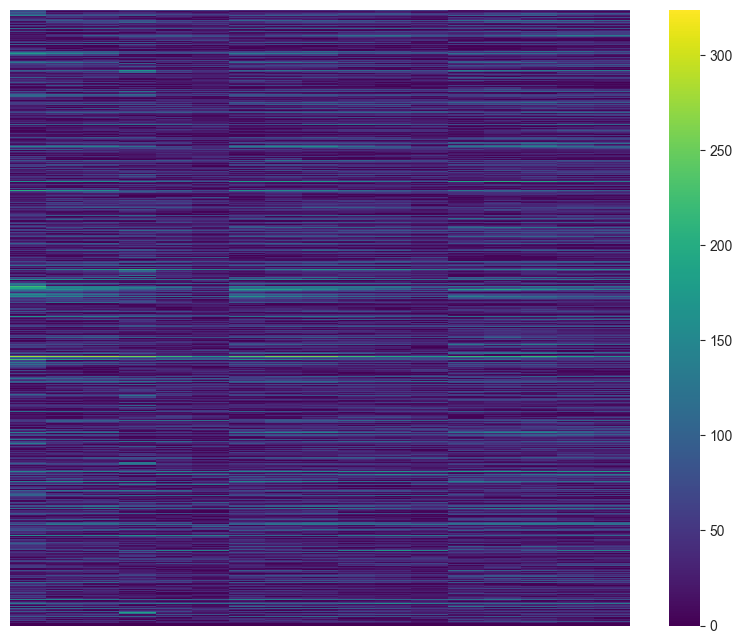

In [147]:
sample_raw = mne.io.read_raw_edf('../files/S001/S001R03.edf')
sample = sample_raw.to_data_frame()
sample_absolute = sample.loc[:, sample.columns != 'time'].abs()
sample_absolute.reset_index(drop=True, inplace=True)
sample_final = preprocessing(sample_absolute)
print(sample_final.describe())
plot_heatmap(sample_final)

In [148]:
data = load_data()
train_images, train_labels, test_images, test_labels = train_test_split(data['heatmap'], data['label'], test_size=0.3, train_size=0.7)


train_images, test_images = train_images / 1000.0, test_images / 1000.0

# Build the model
model = models.Sequential([
    layers.MaxPooling2D((4, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(5000, 17, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# Define a callback to stop training when accuracy reaches 80%
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= 0.80:
            print("\nReached 80% accuracy")
            self.model.stop_training = True

# Compile the model
model.compile(optimizer='adam',
              loss='softmax',
              metrics=['accuracy'])

# Train the model with the callback
model.fit(train_images, train_labels, epochs=10, 
          validation_data=(test_images, test_labels), 
          callbacks=[CustomCallback()])

Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S001\S001R06.edf...
EDF file 

C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: Ru

Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S100\S100R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S100\S100R11.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S100\S100R12.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S100\S100R13.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S100\S100R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\

C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne.io.read_raw_edf(path)
C:\Users\joshu\AppData\Local\Temp\ipykernel_10616\2254410660.py:25: Ru

Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S101\S101R02.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S101\S101R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S101\S101R04.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S101\S101R05.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\joshu\Documents\Github\eeg_ml\files\S101\S101R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1526,) + inhomogeneous part.